# LINK Price Predictions

My project will consist of looking into ways to create price predictions on the cryptocurrency LINK. There are many machine learning models which are created in order to make predictions on other major currencies such as BTC and ETH. However, those are some of the most stable and predictible currencies due to their large following and heavy amount of data surrounding them. I am looking into how feasible it is to predict lesser known cryptocurrencies with far less of a following and data available surrounding it. I believe that due to its heightened volitility and significantly less available data, it will not be very easy to create a machine learning model which predicts daily movements with signifiantly more than 50% accuracy.

In [65]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from xgboost import XGBClassifier

       Date      Open      High       Low     Close  Adj Close      Volume
0  1/1/2019  0.289458  0.301980  0.289407  0.299371   0.299371   1522529.0
1  1/2/2019  0.300770  0.318269  0.297464  0.316489   0.316489   1637715.0
2  1/3/2019  0.316530  0.372249  0.315525  0.365974   0.365974  10890273.0
3  1/4/2019  0.368733  0.450038  0.367064  0.437175   0.437175  24652793.0
4  1/5/2019  0.439706  0.443555  0.387636  0.395948   0.395948  13064911.0


<Axes: xlabel='Date', ylabel='Close'>

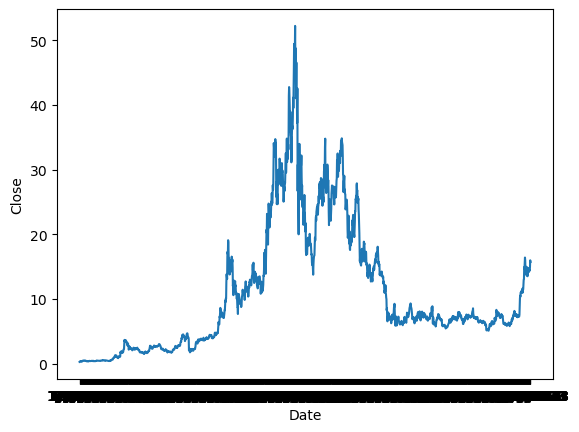

In [66]:
# Upload the LINK-USD csv file that is from yahoo finance
# This is a time-series dataset which gives us the opening, high, low, and close prices as well as the volume of trades on each day

link_data = pd.read_csv("LINK-USD.csv")
print(link_data.head())

# We initially just want to plot the data in order to get a sense of the price movement over time in our data.

sns.lineplot(data=link_data, x="Date", y="Close")

In [67]:
# Deleting the adjusted close column from the dataframe. This column is not necessary as LINK does not include stock splits or halving. 
# This means that the close and adjusted close will always be the same

del link_data['Adj Close']

# Creating a column that provides us with the close data tomorrow. This change between today's close and tomorrow's is what we are looking to predict.

link_data['Tomorrow Price'] = link_data['Close'].shift(-1)
link_data['Change'] = (link_data['Tomorrow Price'] > link_data['Close']).astype(int)


In [68]:
print(link_data.head())

       Date      Open      High       Low     Close      Volume  \
0  1/1/2019  0.289458  0.301980  0.289407  0.299371   1522529.0   
1  1/2/2019  0.300770  0.318269  0.297464  0.316489   1637715.0   
2  1/3/2019  0.316530  0.372249  0.315525  0.365974  10890273.0   
3  1/4/2019  0.368733  0.450038  0.367064  0.437175  24652793.0   
4  1/5/2019  0.439706  0.443555  0.387636  0.395948  13064911.0   

   Tomorrow Price  Change  
0        0.316489       1  
1        0.365974       1  
2        0.437175       1  
3        0.395948       0  
4        0.397010       1  


In [69]:
# Creating a random forest model to use as our base model to check 
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=10)

In [70]:
data_length = len(link_data.index)

# Splitting the data into training and testing datasets

train_data = link_data[:-int((data_length*0.6))]
test_data = link_data[-int((data_length*0.2)):]

In [71]:
predictor_variables = ["Open", "High", "Low", "Close", "Volume"]

# Fit the Random Forest model that we put together on the training data

rf_model.fit(train_data[predictor_variables], train_data["Change"])

# Create predictions from the fit model using the test data and caclculate the accuracy of our predictions versus their observed "Change" value

predictions = rf_model.predict(test_data[predictor_variables])
predictions = pd.Series(predictions)

precision_score(test_data["Change"], predictions)

0.4827586206896552

Overall, our first model only gives us prediction accuracy of around 48%. This is not much different than simply flipping a coin, which gives us no confidence in the accuracy of this initial model.

Next, we will look to implement more data in order to see its effect on the accuracy of our model. This new dataset is common in the cyrpto community as it deliniates the overall fear and greed indexes of investors on the overall marketplace.

In [72]:

sentiment_data = pd.read_csv("fear_and_greed_sentiment.csv")

# Remove unnecessary data fields as well as narrow down the date field to match that as that from our LINK price data.

del sentiment_data['Value']
del sentiment_data['Value_Classification']

# Need to convert the "Date" field to a date type to ensure that the filter works and our merge with LINK price data later works.

sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])
sentiment_data = sentiment_data[sentiment_data['Date'] >= '2019-01-01']


print(sentiment_data['Date'].max())

2023-03-31 00:00:00


In [73]:
# Ensure the same for the date field for the LINK price data and then filter down the data by the max in the sentiment data set that we just returned.
link_data['Date'] = pd.to_datetime(link_data['Date'])
link_data = link_data[link_data['Date'] <= sentiment_data['Date'].max()]

# Validate that the date ranges are the same and then merge the two datasets together

print(link_data['Date'].max() == sentiment_data['Date'].max())
print(link_data['Date'].min() == sentiment_data['Date'].min())

merged_data = pd.merge(link_data, sentiment_data, on='Date')

print(merged_data.head())

True
True
        Date      Open      High       Low     Close      Volume  \
0 2019-01-01  0.289458  0.301980  0.289407  0.299371   1522529.0   
1 2019-01-02  0.300770  0.318269  0.297464  0.316489   1637715.0   
2 2019-01-03  0.316530  0.372249  0.315525  0.365974  10890273.0   
3 2019-01-04  0.368733  0.450038  0.367064  0.437175  24652793.0   
4 2019-01-05  0.439706  0.443555  0.387636  0.395948  13064911.0   

   Tomorrow Price  Change  Fear  Extreme Fear  Neutral  Greed  Extreme Greed  
0        0.316489       1     0            24        0      0              0  
1        0.365974       1    30             0        0      0              0  
2        0.437175       1    33             0        0      0              0  
3        0.395948       0     0             0       48      0              0  
4        0.397010       1    36             0        0      0              0  


In [74]:
rf_model_2 = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=10)

merged_length = len(merged_data.index)

# Splitting the data into training and testing datasets

train_data_2 = merged_data[:-int((merged_length*0.6))]
test_data_2 = merged_data[-int((merged_length*0.2)):]


predictor_variables_2 = ["Open", "High", "Low", "Close", "Volume", "Fear", "Extreme Fear", "Neutral", "Greed", "Extreme Greed"]
rf_model_2.fit(train_data_2[predictor_variables_2], train_data_2["Change"])

# Create predictions from the fit model using the test data and caclculate the accuracy of our predictions versus their observed "Change" value

predictions_2 = rf_model_2.predict(test_data_2[predictor_variables_2])
predictions_2 = pd.Series(predictions_2)

precision_score(test_data_2["Change"], predictions_2)

0.49557522123893805

Incorporating the sentiment data on the state of the market has increased the accuracy of the model, but only by a very small amount at 1.13%. Some further investigation into ensuring we are utilizing the best parameters for our machine learning model should be analyzed next.

In [75]:
# Defining prediction and backtesting functions

def predict(train, test, predictor_variables, model):
    model.fit(train[predictor_variables], train["Change"])
    preds = model.predict(test[predictor_variables])
    preds = pd.Series(preds, index=test.index, name="predictions")
    pred_and_real = pd.concat([test["Change"], preds], axis=1)
    return pred_and_real


# Splitting the data into training and testing datasets


def backtesting(data, model, predictor_variables, start= 730, step= 90):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictor_variables, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)



In [76]:
model_new = XGBClassifier(random_state=1, learning_rate=0.1, n_estimators=200)
final_predictions = backtesting(merged_data, model_new, predictor_variables_2)

final_predictions["predictions"].value_counts()

precision_score(final_predictions["Change"], final_predictions["predictions"])

0.5364431486880467

We can see the the implementation of the new XG Boost Classifier as well as the backtesting has again increased the prediction accuracy now by 4.1%. These clearly are deemed as meaningful contributions towards the overall accuracy of our model and should be kept as we look for other possible predictor variables which might help us predict LINK's next day price change.

I would like to explore further to see if we can further enhance the accuracy of this model by incorporating some foundational investment statistics including a 30 day moving average on change, 60 day moving average on change, and Bollinger bands.

In [77]:
# Adding in the moving averages to the merged data set

merged_data['30_day_ma'] = merged_data['Change'].rolling(30).mean()
merged_data['60_day_ma'] = merged_data['Change'].rolling(60).mean()

# Re-run the exact same Random Forest alogithm in order to test for the effect of the additional moving average datapoints

predictor_variables_with_ma = ["Open", "High", "Low", "Close", "Volume", "Fear", "Extreme Fear", "Neutral", "Greed", "Extreme Greed", "30_day_ma", "60_day_ma"]

model_new = XGBClassifier(random_state=1, learning_rate=0.1, n_estimators=200)
final_predictions = backtesting(merged_data, model_new, predictor_variables_with_ma)

final_predictions["predictions"].value_counts()

precision_score(final_predictions["Change"], final_predictions["predictions"])


0.5781710914454278

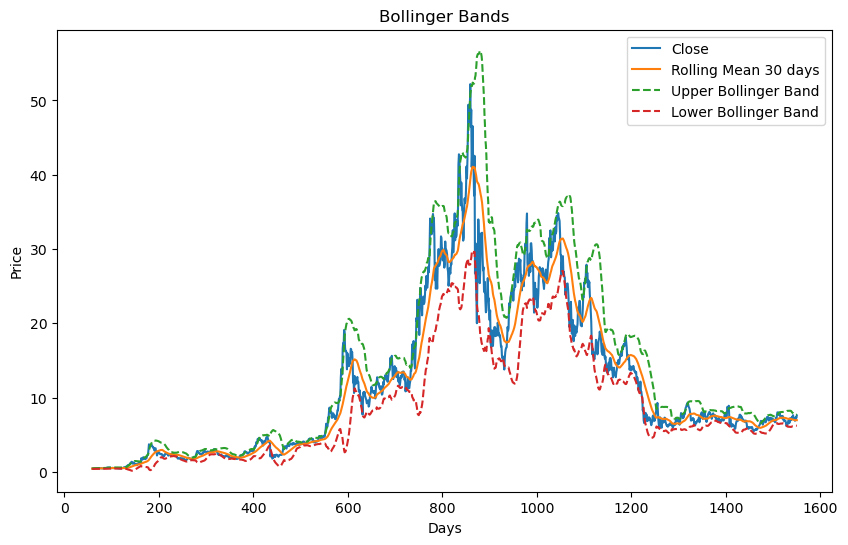

In [78]:
data_copy = merged_data.copy()

def Rolling_Mean_Bollinger_Bands(data, window_size):
    
    data['RollingMean'] = data['Close'].rolling(window=window_size).mean()
    data['UpperBand'] = data['RollingMean'] + 2 * data['Close'].rolling(window=window_size).std()
    data['LowerBand'] = data['RollingMean'] - 2 * data['Close'].rolling(window=window_size).std()

    return data

graph_data = Rolling_Mean_Bollinger_Bands(data_copy, window_size=30)

graph_data = graph_data.dropna()

# Plot the data with Bollinger Bands

plt.figure(figsize=(10, 6))
plt.plot(graph_data['Close'], label='Close')
plt.plot(graph_data['RollingMean'], label=f'Rolling Mean 30 days')
plt.plot(graph_data['UpperBand'], label='Upper Bollinger Band', linestyle='dashed')
plt.plot(graph_data['LowerBand'], label='Lower Bollinger Band', linestyle='dashed')
plt.title('Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

We can see by the above visual that there are many instances in which the Close price has crossed the upper Bollinger band. These closings might be slightly overvalued and have more of a risk of decreasing by next closing day. Let's consolidate the data to when these instances occur and see their frequency of positive versus negative changes to the next day compared to times when these instances do not occur.

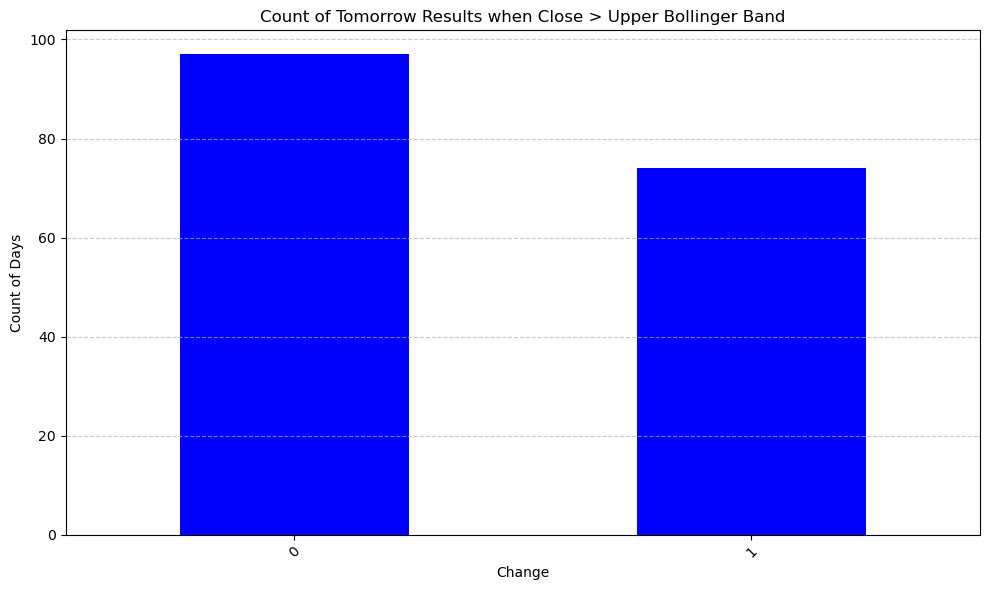

In [79]:
possible_overvalue_data = graph_data[graph_data['Close'] > graph_data['UpperBand']]

possible_overvalue_data_2 = possible_overvalue_data[['Date', 'Change']].copy()

grouped_data = possible_overvalue_data_2.groupby('Change')['Date'].count()

plt.figure(figsize=(10, 6))  # Setting figure size
grouped_data.plot(kind='bar', color='blue')  # Creating bar chart
plt.title('Count of Tomorrow Results when Close > Upper Bollinger Band')  # Setting title
plt.xlabel('Change')  # Setting x-axis label
plt.ylabel('Count of Days')  # Setting y-axis label
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding gridlines
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()  # Displaying the plot


Although not strongly correlated, there is a positive correlation between closing prices being greater than the upper bollinger band (signal of possible overvaluation) and the next day's closing price decreasing. Let's take a look and see if we notice a similar effect when the closing price sinks below the lower bollinger band.

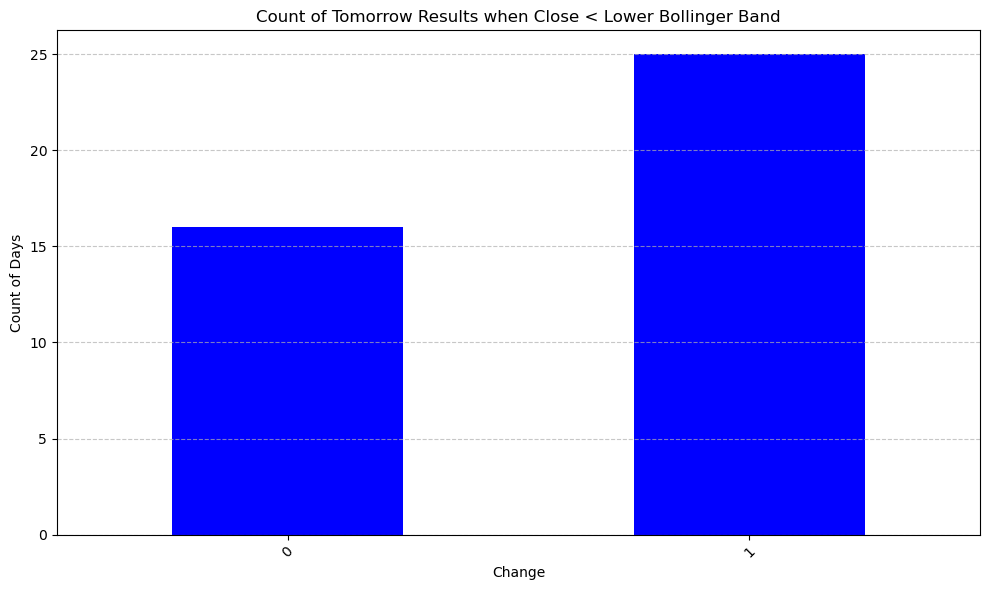

In [80]:
possible_undervalue_data = graph_data[graph_data['Close'] < graph_data['LowerBand']]

possible_undervalue_data_2 = possible_undervalue_data[['Date', 'Change']].copy()

grouped_data_2 = possible_undervalue_data_2.groupby('Change')['Date'].count()

plt.figure(figsize=(10, 6))  # Setting figure size
grouped_data_2.plot(kind='bar', color='blue')  # Creating bar chart
plt.title('Count of Tomorrow Results when Close < Lower Bollinger Band')  # Setting title
plt.xlabel('Change')  # Setting x-axis label
plt.ylabel('Count of Days')  # Setting y-axis label
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding gridlines
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()  # Displaying the plot

Again, we see some type of correlation between these significant outliers in the price data and their next day's change result. Due to this, we would like to take these specific instances into account by creating two new features which tag these as categorical variables.

In [81]:
final_data = graph_data.copy()

final_data['overvalue_outlier'] = (final_data['Close'] > final_data['UpperBand']).astype(int)
final_data['undervalue_outlier'] = (final_data['Close'] < final_data['LowerBand']).astype(int)

#Create final predicition incorporating new indicators

final_predicor_variables = ["Open", "High", "Low", "Close", "Volume", "Fear", "Extreme Fear", "Neutral", "Greed", "Extreme Greed", "30_day_ma", "60_day_ma", "overvalue_outlier", "undervalue_outlier"]

final_predictions = backtesting(final_data, model_new, final_predicor_variables)

final_predictions["predictions"].value_counts()

precision_score(final_predictions["Change"], final_predictions["predictions"])



0.5855855855855856

Though we were able to increase our precision score with the addition of the two outlier indicators, it was not a significant increase. This is mostly due to the fact that only 14% of the dataset consists of these outliers. Overall, through review and experimentation with additional variables, we were able to get to a precision score of 58.55% which is a major improvement from the 50/50 chance that we were seeing initially.